In [2]:
!wget -N https://lcps.nu/wp-content/uploads/covid-19.csv

--2020-10-18 17:17:29--  https://lcps.nu/wp-content/uploads/covid-19.csv
Resolving lcps.nu (lcps.nu)... 62.221.199.13, 2001:1460:3:0:1c00:d3ff:fe00:cb9
Connecting to lcps.nu (lcps.nu)|62.221.199.13|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘covid-19.csv’ not modified on server. Omitting download.



Get Pandas and NumPy for feature engineering and calculations and get plots inline.

In [3]:
import pandas as pd
import numpy  as np

from pyearth import Earth
from pyearth import export

%matplotlib inline

We read our dataframe directly from the downloaded Excel file and have a look at the first 10 lines for format. Data for Namibia caused missing values because the `geoId` is __NA__, so we disable interpretation of missing values.

In [4]:
df = pd.read_csv('covid-19.csv', keep_default_na=False, na_values='', parse_dates=[0], dayfirst=True)
df.head(10)

Datum  IC_Bedden_COVID  IC_Bedden_Non_COVID  Kliniek_Bedden  \
0 2020-06-01              157                  488             542   
1 2020-06-02              153                  476             516   
2 2020-06-03              116                  514             496   
3 2020-06-04              113                  567             481   
4 2020-06-05               97                  543             469   
5 2020-06-06               96                  549             456   
6 2020-06-07               96                  502             443   
7 2020-06-08               93                  533             400   
8 2020-06-09               91                  521             346   
9 2020-06-10               80                  535             333   

   IC_Nieuwe_Opnames_COVID  Kliniek_Nieuwe_Opnames_COVID  
0                      NaN                           NaN  
1                      NaN                           NaN  
2                      NaN                           NaN  
3                      NaN                           NaN  
4                      NaN                           NaN  
5                      NaN                           NaN  
6                      NaN                           NaN  
7                      NaN                           NaN  
8                      NaN                           NaN  
9                      NaN                           NaN

Adding structure and dummy variables, last check of our source dataframe.

In [5]:
df['Source'] = 'LCPS'
df['Capacity'] = 1
df['IC_totaal'] = df['IC_Bedden_COVID'] + df['IC_Bedden_Non_COVID']
df.describe().transpose()

count        mean         std    min     25%  \
IC_Bedden_COVID               140.0   73.357143   76.663055   14.0   27.75   
IC_Bedden_Non_COVID           140.0  568.185714   35.431479  460.0  544.75   
Kliniek_Bedden                140.0  278.035714  291.448168   63.0   91.00   
IC_Nieuwe_Opnames_COVID         2.0   35.000000    9.899495   28.0   31.50   
Kliniek_Nieuwe_Opnames_COVID    2.0  211.000000    7.071068  206.0  208.50   
Capacity                      140.0    1.000000    0.000000    1.0    1.00   
IC_totaal                     140.0  641.542857   67.969880  537.0  594.75   

                                50%     75%     max  
IC_Bedden_COVID                38.0   91.00   364.0  
IC_Bedden_Non_COVID           572.0  592.00   646.0  
Kliniek_Bedden                134.5  336.25  1288.0  
IC_Nieuwe_Opnames_COVID        35.0   38.50    42.0  
Kliniek_Nieuwe_Opnames_COVID  211.0  213.50   216.0  
Capacity                        1.0    1.00     1.0  
IC_totaal                     623.0  659.00   869.0

We pivot to a source by column format.

In [6]:
# File parameters prefixed pf_

pf_datcol = 'Datum'                       # date column
pf_dimcol = 'Source'                      # dimension column (location or otherwise)
pf_cascol = ['IC_Bedden_COVID', 'IC_Bedden_Non_COVID', 'Kliniek_Bedden', 'IC_totaal']
pf_namcol = 'Source'                      # full dim name
pf_popcol = 'Capacity'                    # population column

pf_futext = '365 days'                    # future extension of dataframe

In [7]:
df_dim = df.pivot_table(index=pf_datcol, columns=pf_dimcol, values=pf_cascol, aggfunc='sum').fillna(0)
df_dim

IC_Bedden_COVID IC_Bedden_Non_COVID IC_totaal Kliniek_Bedden
Source                LCPS                LCPS      LCPS           LCPS
Datum                                                                  
2020-06-01             157                 488       645            542
2020-06-02             153                 476       629            516
2020-06-03             116                 514       630            496
2020-06-04             113                 567       680            481
2020-06-05              97                 543       640            469
...                    ...                 ...       ...            ...
2020-10-14             301                 527       828           1174
2020-10-15             313                 503       816           1213
2020-10-16             345                 524       869           1208
2020-10-17             352                 492       844           1216
2020-10-18             364                 460       824           1288

[140 rows x 4 columns]

For predictions later on we need extra rows in our dataframe. One of the ways to do that is reindexing with a larger range, so we add to the current range and check our latest date.

In [8]:
new_index = pd.date_range(df_dim.index.min(), df_dim.index.max() + pd.Timedelta(pf_futext))
df_dim = df_dim.reindex(new_index)
df_dim

IC_Bedden_COVID IC_Bedden_Non_COVID IC_totaal Kliniek_Bedden
Source                LCPS                LCPS      LCPS           LCPS
2020-06-01           157.0               488.0     645.0          542.0
2020-06-02           153.0               476.0     629.0          516.0
2020-06-03           116.0               514.0     630.0          496.0
2020-06-04           113.0               567.0     680.0          481.0
2020-06-05            97.0               543.0     640.0          469.0
...                    ...                 ...       ...            ...
2021-10-14             NaN                 NaN       NaN            NaN
2021-10-15             NaN                 NaN       NaN            NaN
2021-10-16             NaN                 NaN       NaN            NaN
2021-10-17             NaN                 NaN       NaN            NaN
2021-10-18             NaN                 NaN       NaN            NaN

[505 rows x 4 columns]

We need numerical data as inputs for a model, so we add a column representing the date as days since the start of the index.

In [9]:
df_dim['daynum'] = (df_dim.index - df_dim.index.min()).days
df_dim['daynum'].describe()

count    505.000000
mean     252.000000
std      145.925209
min        0.000000
25%      126.000000
50%      252.000000
75%      378.000000
max      504.000000
Name: daynum, dtype: float64

The typical progress of an outbreak seems to fit a Gumbel distribution, where the cumulative distribution is a double negative exponent: `exp(-exp(-x))`.

In [10]:
def gumpdf(x, beta, mu):
    """Return PDF value according to Gumbel"""
    expon = - ((x - mu) / beta)
    return(np.exp(expon) * np.exp(- (np.exp(expon))) / beta)

def gumcdf(x, beta, mu):
    """Return CDF value according to Gumbel"""
    expon = - ((x - mu) / beta)
    return(np.exp(- (np.exp(expon))))

In [11]:
# Run parameters prefixed pr_

pr_dim      = 'LCPS'                      # dimension indicator (geo or otherwise)

pr_measure  = 'IC_Bedden_COVID'           # file column to use as measure
pr_smeasure = 'Week window'               # smoothed measures
pr_rmeasure = 'rcases'                    # remaining measures after iteration
pr_pmeasure = 'Model'                     # projected measures summed
pr_wmeasure = 'Wave '                     # wave name prefix, zero-leading number is added
pr_wavenum  = 2                           # wave numbering width

pr_sdays    = 7                           # number of days for smoothing window
pr_firstwav = 1                           # initial wave number
pr_popcases = 1e6                         # relative minimum from population size (one in n cases)
pr_mincases = 2                           # absolute minimum number of cases to consider

pr_linmax   = -1/2                        # upper bound of linear derivation
pr_linmin   = -9/2                        # lower bound of linear derivation
pr_betamax  = 33                          # maximum accepted beta estimate
pr_datamin  = 3                           # minimum number of data points in spline
pr_projmin  = 1                           # minimum cases for projected start and floor
pr_gradmin  = 1e-6                        # minimum gradient difference for knot

pr_plotmin  = '20200701'                  # start date of output plots
pr_plotmax  = '20210101'                  # final date of output plots

pr_earth = {'minspan'     : 1,
            'penalty'     : 0,
            'endspan'     : 0,
            'thresh'      : 1e-9,
            'check_every' : 1} 

In [12]:
wave = pr_firstwav

# Initialize predicted measure, create smoothed measure and remaining cases
df_dim[(pr_pmeasure, pr_dim)] = 0
df_dim[(pr_smeasure, pr_dim)] = df_dim[pr_measure][pr_dim].loc[:].rolling(pr_sdays).mean()
df_dim[(pr_rmeasure, pr_dim)] = df_dim[pr_smeasure][pr_dim]

# Always plot smoothed and predicted measures, adding waves when found
plotlist = [(pr_smeasure, pr_dim), (pr_pmeasure, pr_dim)]

In [13]:
# Get full name and population from the original dataset
dimnam = df[df[pf_dimcol] == pr_dim][pf_namcol].iloc[0]
dimpop = df[df[pf_dimcol] == pr_dim][pf_popcol].iloc[0]

# We use relative minimum cases, but at least an absolute minimum
mincases = max(dimpop / pr_popcases, pr_mincases)

In [14]:
print('Running multiple wave analysis for {} with population {:1.0f}'.format(dimnam, dimpop))
print('Minimum number of cases is {:1.0f}'.format(mincases))

while True:
    # Create potential wave
    curwave = pr_wmeasure + str((wave) + (10 ** pr_wavenum))[-pr_wavenum:]
    df_dim[(curwave, pr_dim)] = 0

    # Create a dataframe for projections
    df_proj = pd.DataFrame({'daynum':df_dim['daynum'],
                            'measure':df_dim[pr_rmeasure][pr_dim]})

    # Create the Gumbel division and select suitable measures
    df_proj['gumdiv'] = df_proj['measure'] / df_proj['measure'].cumsum()
    df_proj = df_proj[(df_proj['gumdiv'] > 0) & (df_proj['measure'] > mincases)]

    # Reduce to log scale and select relevant measures
    df_proj['linear'] = np.log(df_proj['gumdiv'])
    df_proj = df_proj[(df_proj['linear'] < pr_linmax) &
                      (df_proj['linear'] > pr_linmin)]

    # Do we still have data left?
    if len(df_proj) <= 1:
        print('--- no data left')
        break
    
    # Create input vectors for regression splines and build a model
    eax = df_proj['daynum'].values.reshape(-1, 1)
    eay = df_proj['linear'].values.reshape(-1, 1)
    #eamodel = Earth()
    #eamodel = Earth(minspan=0)
    eamodel = Earth(minspan=1, penalty=0, endspan=0, thresh=1e-9, check_every=1)
    eamodel.fit(eax, eay)

    # Store the results
    df_proj['earth'] = eamodel.predict(eax)

    # Find the day range
    daymin = df_proj['daynum'].min()
    daymax = df_proj['daynum'].max()

    # Find the gradient of generated regression splines
    df_proj['eagrad'] = df_proj['earth'] - df_proj['earth'].shift(1)
    
    # Knots are found when the gradient changes, including start and end
    df_proj['knot'] = ((abs(df_proj['eagrad'] - df_proj['eagrad'].shift(1)) > pr_gradmin) |
                       (df_proj['daynum'] == (daymin + 1)) |
                       (df_proj['daynum'] == daymax))

    # Starting day of each spline
    df_proj['daycount'] = df_proj.reset_index().index

    # Select the knots and find the actual number of days for each spline
    df_knot = df_proj[df_proj['knot']][['daynum', 'daycount', 'eagrad']]
    df_knot['daysdata'] = df_knot['daycount'].shift(-1) - df_knot['daycount']
    
    # Candidate knots have a negative gradient and a minimum number of days
    df_knot['cand'] = ((df_knot['eagrad'] < -(1 / pr_betamax)) &
                       (df_knot['daysdata'] >= pr_datamin))

    # We want early knots with a low gradient and many days
    df_knot['since'] = df_knot['daynum'] - daymin
    df_knot['score'] = (df_knot['eagrad'] ** 2) * np.sqrt(df_knot['daysdata'] / np.sqrt(df_knot['since']))
    df_knot['choice'] = df_knot['score'] == df_knot[df_knot['cand']]['score'].max()

    # Did we find another wave?
    choice = df_knot[df_knot['choice']]
    if len(choice) == 0:
        print('--- no data for wave')
        break
    
    # Find the interval of the selected spline
    lower = choice['daynum'].values[0]
    upper = choice['daysdata'].values[0] + lower
    df_proj = df_proj[(df_proj['daynum'] >= lower) &
                      (df_proj['daynum'] <= upper)].copy()

    # Calculate slope and intercept as basis for beta and mu
    fitmod = export.export_python_function(eamodel)
    slope = (fitmod([[upper]])[0] - fitmod([[lower]])[0]) / (upper - lower)
    intercept = fitmod([[lower]])[0] - (lower * slope)
    beta = - 1 / slope
    mu = beta * (intercept + np.log(beta))

    # Apply the Gumbel PDF according to beta and mu to find the scale and fit
    df_proj['pgumb'] = gumpdf(df_proj['daynum'], beta, mu)
    df_proj['scale'] = df_proj['measure'] / df_proj['pgumb']
    final = df_proj['scale'].mean()
    fincv = df_proj['scale'].std() / final

    # Calculate the current wave and its parameters
    df_dim[(curwave, pr_dim)] = final * gumpdf(df_dim['daynum'], beta, mu)
    peak = df_dim[df_dim[(curwave, pr_dim)] == df_dim[(curwave, pr_dim)].max()].index.min()
    start = df_dim[(df_dim[(curwave, pr_dim)] >= pr_projmin) &
                   (df_dim[(curwave, pr_dim)].index < peak)].index.min()
    floor = df_dim[(df_dim[(curwave, pr_dim)] < pr_projmin) &
                   (df_dim[(curwave, pr_dim)].index > peak)].index.min()
    print('{} beta {:6.3f} mu {:3.0f} fit {:5.3f} peak {} from {} to {} size {:1.0f}'.format(
        curwave, beta, mu, (1 - fincv) ** 2, peak.date(), start.date(), floor.date(), final))

    # Move the associated measures from remainder to prediction
    df_dim[(pr_pmeasure, pr_dim)] += df_dim[(curwave, pr_dim)]
    df_dim[(pr_rmeasure, pr_dim)] -= df_dim[(curwave, pr_dim)]
    plotlist += [(curwave, pr_dim)]
    wave += 1

Running multiple wave analysis for LCPS with population 1
Minimum number of cases is 2
Wave 01 beta  3.907 mu   9 fit 0.888 peak 2020-06-10 from 2020-06-03 to 2020-07-02 size 1053
Wave 02 beta  8.484 mu  21 fit 0.905 peak 2020-06-22 from 2020-06-06 to 2020-08-03 size 1153
Wave 03 beta  5.238 mu  45 fit 0.889 peak 2020-07-16 from 2020-07-08 to 2020-08-05 size 211
Wave 04 beta  7.875 mu  63 fit 0.912 peak 2020-08-03 from 2020-07-21 to 2020-09-02 size 339
Wave 05 beta  5.515 mu  72 fit 0.908 peak 2020-08-12 from 2020-08-03 to 2020-09-03 size 272
Wave 06 beta  9.257 mu  88 fit 0.814 peak 2020-08-28 from 2020-08-11 to 2020-10-10 size 970
Wave 07 beta  5.558 mu 107 fit 0.834 peak 2020-09-16 from 2020-09-07 to 2020-10-09 size 338
Wave 08 beta  7.044 mu 118 fit 0.903 peak 2020-09-27 from 2020-09-14 to 2020-11-03 size 1241
Wave 09 beta  7.891 mu 128 fit 0.917 peak 2020-10-07 from 2020-09-21 to 2020-11-21 size 2302
Wave 10 beta  5.903 mu 136 fit 0.901 peak 2020-10-15 from 2020-10-03 to 2020-11-1

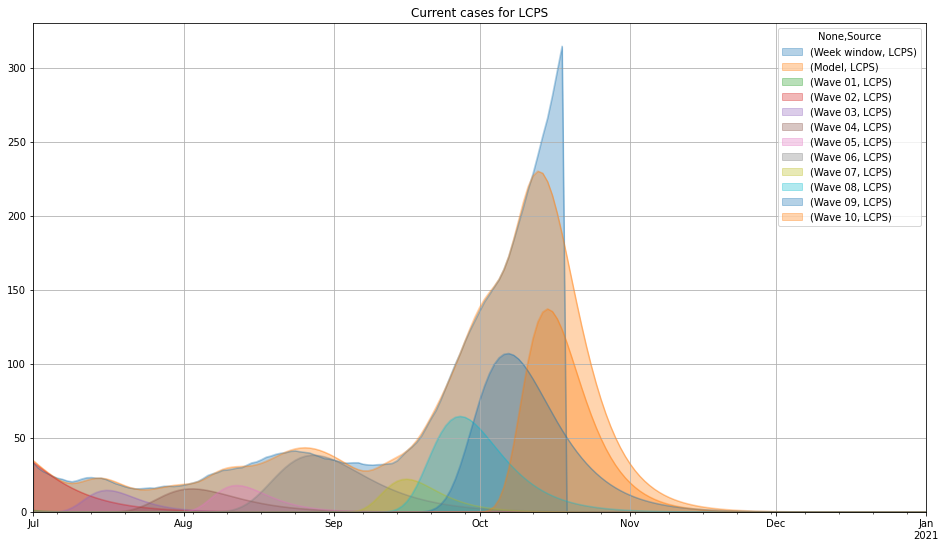

In [15]:
df_dim[plotlist].loc[pr_plotmin:pr_plotmax].plot(
    figsize=(16, 9),
    grid=True,
    kind='area',
    stacked=False,
    alpha=1/3,
    title='Current cases for '+dimnam)

Residuals from fit are the cases left.

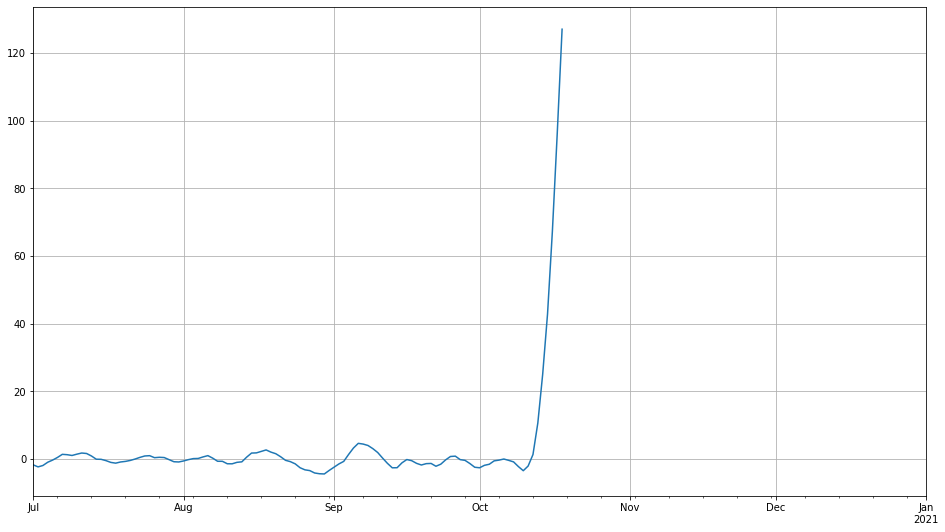

In [16]:
(df_dim[(pr_smeasure, pr_dim)] - df_dim[(pr_pmeasure, pr_dim)]).loc[pr_plotmin:pr_plotmax].plot(
    figsize=(16, 9), grid=True)

Keep exploring! Stay home, wash your hands, keep your distance.